In [60]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hridaym25/burgers-equation-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/burgers-equation-dataset


In [62]:
from scipy.io import loadmat                   # Import function to load MATLAB .mat files
import os                                      # Import for handling file paths
import jax.numpy as jnp                        # Import JAX's NumPy for array operations

file_to_load = os.path.join(path, 'burgers_shock.mat')  # Create full path to the .mat file

data = loadmat(file_to_load)                  # Load the .mat file as a dictionary
x_data = data['x']                             # Extract spatial grid 'x' from the file
y_data = data['usol']                          # Extract solution matrix 'usol' (u(x,t)) as target
y_data = jnp.asarray(y_data)                   # Convert target data to JAX array
x_data = jnp.asarray(x_data)                   # Convert input data to JAX array

In [63]:
def u_i(i):
    return y_data[:, i]       # Returns the solution u(x, t_i) at time index i (all spatial points)

def x_i(i):
    return x_data[i]          # Returns the spatial coordinate at index i

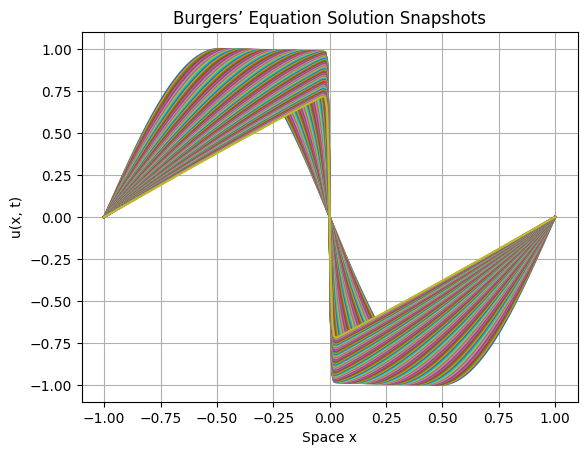

In [137]:
for i in range(1,100):
      plt.plot(x_data, u_i(i))

plt.xlabel('Space x')
plt.ylabel('u(x, t)')
plt.title('Burgers’ Equation Solution Snapshots')
plt.grid(True)
plt.show()

In [81]:
from flax import nnx
import jax
import jax.numpy as jnp

# Branch network
class Branch(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(256, 100, rngs=rngs)
        self.linear2 = nnx.Linear(100, 40, rngs=rngs)

    def __call__(self, x):
        x = nnx.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

# Trunk network
class Trunk(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(1, 40, rngs=rngs)
        self.linear2 = nnx.Linear(40, 40, rngs=rngs)
        self.linear3 = nnx.Linear(40, 40, rngs=rngs)

    def __call__(self, x):
        x = nnx.tanh(self.linear1(x))
        x = nnx.tanh(self.linear2(x))
        x = self.linear3(x)
        return x

# DeepONet with dot-product fusion
class DeepONet(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.branch_net = Branch(rngs=rngs)
        self.trunk_net = Trunk(rngs=rngs)

    def __call__(self, x, y):
        b_out = self.branch_net(x)
        t_out = self.trunk_net(y)
        return jnp.vdot(b_out, t_out)

# Instantiate model
model = DeepONet(rngs=nnx.Rngs(0))

# Optional: Visualize structure
nnx.display(model)

In [135]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

# One step of RK4 method for u(x) at a given spatial point x_i
def rk4_step(model, u_i, x_i, x_data, h=0.01):
    index = jnp.argmin(jnp.abs(x_data - x_i))      # Find closest index in x_data to x_i
    y_value = u_i[index]

    k1 = model(u_i, x_i)
    k2 = model(u_i + 0.5 * h * k1, x_i)
    k3 = model(u_i + 0.5 * h * k2, x_i)
    k4 = model(u_i + h * k3, x_i)

    return y_value + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)  # Weighted sum (RK4 formula)

# Vectorized RK4 over all spatial points in x_data
def rk4_vmap(model, u_i, x_i, x_data, h=0.01):
    return jax.vmap(rk4_step, in_axes=(None, None, 0, None, None))(model, u_i, x_data, x_data, h)

In [134]:
from jax import lax
import jax.numpy as jnp
@nnx.jit
def loss_fn_over_time(model, x_i, x_data, h=0.01):
    u_curr = u_i(0)
    truths = jnp.stack([u_i(i) for i in range(1, 51)])  # shape: (T, N)

    def scan_step(u_i_curr, truth):
        pred = rk4_vmap(model, u_i_curr, x_i, x_data, h)
        loss = jnp.mean((pred - truth) ** 2)
        return pred, loss

    _, losses = lax.scan(scan_step, u_curr, truths)
    return jnp.mean(losses)


loss_fn_over_time(model,x_data, x_data, h=0.01)

Array(4.4770528e-05, dtype=float32)

In [133]:
@nnx.jit
def train_step(model, x_i, x_data, h=0.01):
    grad_fn = nnx.value_and_grad(loss_fn_over_time)  # calculate grads
    loss ,grads = grad_fn(model, x_i, x_data, h=0.01)
    return grads, loss

In [85]:
import optax

learning_rate = 0.001
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum)) # Adam_optimizer
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [124]:
import matplotlib.pyplot as plt

# train_mse = []
num_epochs = 2000            # Total training epochs
for epoch in range(num_epochs):
    grads, loss = train_step(model,x_data, x_data, h=0.01)  # Compute gradients and loss
    train_mse.append(loss)       # Store loss
    optimizer.update(grads=grads)  # Update model parameters
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss}")

Epoch 1/2000, Loss: 0.00011276191071374342
Epoch 2/2000, Loss: 0.00011269086826359853
Epoch 3/2000, Loss: 0.0001126166243921034
Epoch 4/2000, Loss: 0.00011254759010626003
Epoch 5/2000, Loss: 0.00011248364899074659
Epoch 6/2000, Loss: 0.00011241569882258773
Epoch 7/2000, Loss: 0.00011234234989387915
Epoch 8/2000, Loss: 0.00011227170762140304
Epoch 9/2000, Loss: 0.00011220634769415483
Epoch 10/2000, Loss: 0.00011214023106731474
Epoch 11/2000, Loss: 0.00011207006900804117
Epoch 12/2000, Loss: 0.0001120000597438775
Epoch 13/2000, Loss: 0.00011193281534360722
Epoch 14/2000, Loss: 0.00011186656047357246
Epoch 15/2000, Loss: 0.00011179929424542934
Epoch 16/2000, Loss: 0.00011173150414833799
Epoch 17/2000, Loss: 0.00011166419426444918
Epoch 18/2000, Loss: 0.000111597721115686
Epoch 19/2000, Loss: 0.00011153236118843779
Epoch 20/2000, Loss: 0.00011146787437610328
Epoch 21/2000, Loss: 0.00011140354763483629
Epoch 22/2000, Loss: 0.00011134006490465254
Epoch 23/2000, Loss: 0.0001112793106585741
Ep

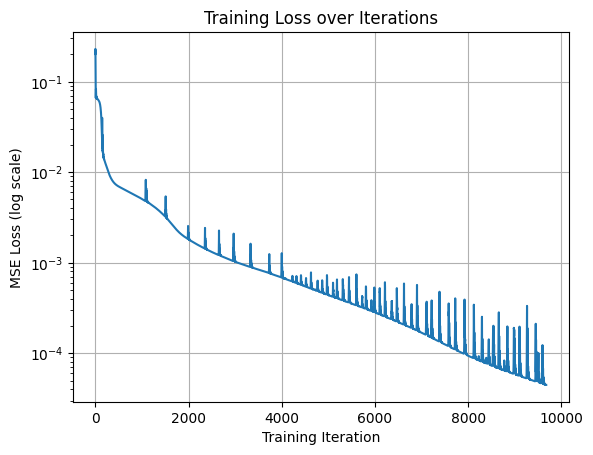

In [125]:
import matplotlib.pyplot as plt

plt.semilogy(train_mse, linestyle='-')
plt.xlabel("Training Iteration")
plt.ylabel("MSE Loss (log scale)")
plt.title("Training Loss over Iterations")
plt.grid(True)
plt.show()

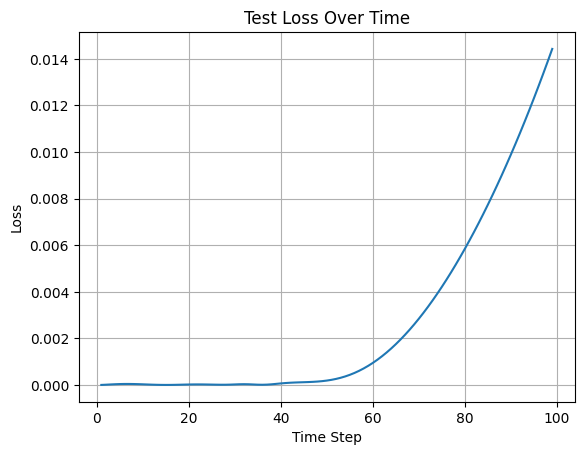

In [126]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Generate test loss
t = rk4_vmap(model, u_i(0), x_data, x_data, h=0.01)
testloss = []

for i in range(1, 100):
    loss = jnp.mean((t - u_i(i))**2)
    testloss.append(loss)
    t = rk4_vmap(model, t, x_data, x_data, h=0.01)

# Plot test loss
plt.plot(jnp.arange(1, 100), jnp.array(testloss))
plt.xlabel("Time Step")
plt.ylabel("Loss")
plt.title("Test Loss Over Time")
plt.grid(True)
plt.show()

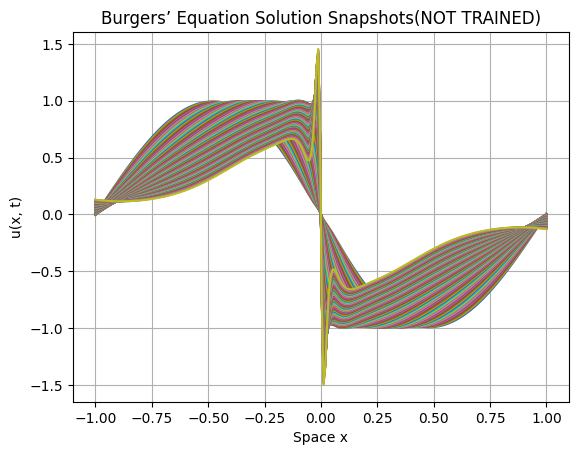

In [132]:
# Apply RK4 time stepping and plot for time snapshots
t = rk4_vmap(model, u_i(0), x_data, x_data,h=0.01)
for i in range(1,100):
  t = rk4_vmap(model, t, x_data, x_data)
  plt.plot(x_data, t)

plt.xlabel('Space x')
plt.ylabel('u(x, t)')
plt.title('Burgers’ Equation Solution Snapshots(NOT TRAINED)')
plt.grid(True)
plt.show()